In [1]:
import os
os.chdir('/home/yajatyadav/multitask_reinforcement_learning/multitask_RL')
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['MUJOCO_GL'] = 'egl'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags
if 'CUDA_VISIBLE_DEVICES' in os.environ:
    os.environ['EGL_DEVICE_ID'] = os.environ['CUDA_VISIBLE_DEVICES']
    os.environ['MUJOCO_EGL_DEVICE_ID'] = os.environ['CUDA_VISIBLE_DEVICES']

import copy
from typing import Any

import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import ml_collections
import optax
import tqdm
import numpy as np
import math
import random

from utils.encoders import encoder_modules
from utils.flax_utils import ModuleDict, TrainState, nonpytree_field, restore_agent_with_file
import pickle
from utils.networks import MLP
from typing import Sequence


from envs.libero_utils import get_dataset as get_libero_dataset, make_env as make_libero_env
from evaluation_libero import evaluate
from utils.log_utils import get_wandb_video

/home/yajatyadav/multitask_reinforcement_learning/multitask_RL/.venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
[robosuite WARNING] No private macro file found! (__init__.py:7)
[robosuite WARNING] It is recommended to use a private macro file (__init__.py:8)
[robosuite WARNING] To setup, run: python /home/yajatyadav/multitask_reinforcement_learning/multitask_RL/.venv/lib/python3.11/site-packages/robosuite/scripts/setup_macros.py (__init__.py:9)


[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [2]:
class TransClassifier(nn.Module):
    hidden_dims: Sequence[int]
    encoder: nn.Module = None    
    layer_norm: bool = True
    p_drop_state: float = 0.5

    def setup(self):
        self.classifier = MLP((*self.hidden_dims,), activate_final=False, layer_norm=self.layer_norm)
    
    def __call__(self, observations, actions, train=True, rng=None):
        # zero-out p_drop_state% of the batch
        assert actions is not None, "Actions must be provided to the classifier"
        assert self.encoder is not None, "Encoder must be provided to the classifier"
        
        observations = self.encoder(observations)

        if rng is None:
            rng = jax.random.PRNGKey(0)
        mask = jax.random.bernoulli(rng, 1 - self.p_drop_state, shape=(observations.shape[0], 1))
        observations = jax.lax.cond(
            train,
            lambda x: mask * x,
            lambda x: x,
            observations
        )
        # jax.debug.print("observations.max(): {}, observations.min(): {}", observations.max(), observations.min())
        inputs = jnp.concatenate([observations, actions], axis=-1)
        return self.classifier(inputs)

In [62]:
# randomize, not simple arange
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

batch_size = 256
horizon_length = 5
discount = 0.99

example_batch = train_dataset.sample_sequence(batch_size, sequence_length=horizon_length, discount=discount)
ex_observations = example_batch['observations']
ex_actions = example_batch['actions']
full_actions = jnp.reshape(ex_actions, (ex_actions.shape[0], -1))
lang_embedding_dim = ex_observations['language'].shape[-1]

encoder = 'image_only_tiny'
hidden_dims = (128,)
layer_norm = True
lr  = 3e-4
p_drop_state = 1.0

rng = jax.random.PRNGKey(SEED)
rng, init_rng = jax.random.split(rng, 2)      

classifier_def = TransClassifier(
    encoder=encoder_modules[encoder](),
    hidden_dims=(*hidden_dims, lang_embedding_dim),
    layer_norm=layer_norm,
    p_drop_state=p_drop_state,
)
        
network_info = dict(
    classifier=(classifier_def, (ex_observations, full_actions, True, init_rng)),
)

networks = {k: v[0] for k, v in network_info.items()}
network_args = {k: v[1] for k, v in network_info.items()}

network_def = ModuleDict(networks)
network_tx = optax.adam(learning_rate=lr)
network_params = network_def.init(init_rng, **network_args)['params']
network = TrainState.create(network_def, network_params, tx=network_tx)

In [63]:
train_percent, val_percent, test_percent = 0.85, 0.05, 0.1
tot_num_demos_per_task = 50
train_num_demos_per_task = int(train_percent * tot_num_demos_per_task)
val_num_demos_per_task = int(val_percent * tot_num_demos_per_task)
test_num_demos_per_task = tot_num_demos_per_task - train_num_demos_per_task - val_num_demos_per_task




shuffled_demo_nums = np.random.permutation(tot_num_demos_per_task)
train_demo_nums_to_use = list(shuffled_demo_nums[:train_num_demos_per_task])
val_demo_nums_to_use = list(shuffled_demo_nums[train_num_demos_per_task:train_num_demos_per_task + val_num_demos_per_task])
test_demo_nums_to_use = list(shuffled_demo_nums[train_num_demos_per_task + val_num_demos_per_task:])

keys_to_load = ['agentview_rgb', 'eye_in_hand_rgb', 'language']
env_name = 'libero_90-living_room_scene1'
task_name = 'pick_up_the_alphabet_soup_and_put_it_in_the_basket|pick_up_the_ketchup_and_put_it_in_the_basket'
augmentation_type = 'none'
augmentation_reward = False

train_dataset = get_libero_dataset(None, env_name, task_name, augmentation_type, augmentation_reward, keys_to_load, demo_nums_to_use_per_task=train_demo_nums_to_use, augmentation_dict=None)
print(f"main.py:Made env and datasets.Train dataset size: {train_dataset.size}", flush=True)
val_dataset = get_libero_dataset(None, env_name, task_name, augmentation_type, augmentation_reward, keys_to_load, demo_nums_to_use_per_task=val_demo_nums_to_use, augmentation_dict=None)
print(f"main.py:Made env and datasets.Val dataset size: {val_dataset.size}", flush=True)
test_dataset = get_libero_dataset(None, env_name, task_name, augmentation_type, augmentation_reward, keys_to_load, demo_nums_to_use_per_task=test_demo_nums_to_use, augmentation_dict=None)
print(f"main.py:Made env and datasets.Test dataset size: {test_dataset.size}", flush=True)

🤪🤪🤪 augmentation_reward: False
all_tasks: ['pick_up_the_alphabet_soup_and_put_it_in_the_basket', 'pick_up_the_ketchup_and_put_it_in_the_basket']
suites: ['libero_90'], scenes: ['living_room_scene1']
🤪🤪🤪 all_libero_env_names: {'libero_90': ['libero_90-LIVING_ROOM_SCENE1_pick_up_the_alphabet_soup_and_put_it_in_the_basket', 'libero_90-LIVING_ROOM_SCENE1_pick_up_the_ketchup_and_put_it_in_the_basket']}
🤪🤪🤪 distinct_scenes: {'libero_90': ['LIVING_ROOM_SCENE1']}
😈😈😈 target_task_name='pick_up_the_alphabet_soup_and_put_it_in_the_basket'
😎😎😎 ONLY using [np.int64(31), np.int64(29), np.int64(10), np.int64(42), np.int64(14), np.int64(21), np.int64(6), np.int64(45), np.int64(9), np.int64(32), np.int64(13), np.int64(39), np.int64(30), np.int64(28), np.int64(15), np.int64(12), np.int64(19), np.int64(37), np.int64(2), np.int64(22), np.int64(23), np.int64(38), np.int64(48), np.int64(18), np.int64(26), np.int64(7), np.int64(3), np.int64(25), np.int64(41), np.int64(4), np.int64(20), np.int64(35), np.int64

In [64]:
train_losses, val_losses = [], []
val_accuracies = []
grad_max, grad_min, grad_norm = [], [], []

def get_loss_fn(batch, train, rng):
    def loss_fn(grad_params):
        masked_actions = batch['actions'] * batch['masks'][..., None]
        batch_actions = jnp.reshape(masked_actions, (masked_actions.shape[0], -1))
        true_lang = batch['observations'].pop('language')
        pred_lang = network.select('classifier')(batch['observations'], batch_actions, params=grad_params, train=train, rng=rng)
        classifier_loss = jnp.mean(optax.losses.softmax_cross_entropy(pred_lang, true_lang))
        return classifier_loss, {
            'classifier_loss': classifier_loss,
        }
    return loss_fn

def accuracy(network, batch):
    true_lang = batch['observations'].pop('language')
    batch_masked_actions = batch['actions'] * batch['masks'][..., None]
    batch_actions = jnp.reshape(batch_masked_actions, (batch_masked_actions.shape[0], -1))
    pred_lang_logits = network.select('classifier')(batch['observations'], batch_actions, train=False, params=network.params)
    pred_lang = jax.nn.softmax(pred_lang_logits)
    # print(test_pred_lang.shape)
    # print(test_true_lang.shape)
    # argmax both
    pred_lang_argmax = jnp.argmax(pred_lang, axis=-1)
    true_lang_argmax = jnp.argmax(true_lang, axis=-1)
    num_correct = jnp.sum(pred_lang_argmax == true_lang_argmax)
    num_total = pred_lang_argmax.shape[0]
    return num_correct, num_total
    

@jax.jit
def update(network, batch, rng):
    new_rng, rng = jax.random.split(rng)
    loss_fn = get_loss_fn(batch, True, rng)
    new_network, info = network.apply_loss_fn(loss_fn=loss_fn)
    network, rng = new_network, new_rng
    return network, rng, info

print(train_dataset.size)
NUM_EPOCHS = 20
num_train_steps = NUM_EPOCHS * math.ceil(train_dataset.size / batch_size)
VAL_INTERVAL = 10
for step in tqdm.tqdm(range(1, num_train_steps+1), total=num_train_steps, desc="Training"):
    batch = train_dataset.sample_sequence(batch_size, sequence_length=horizon_length, discount=discount)
    network, rng, info = update(network, batch, rng)
    train_losses.append((step, info['classifier_loss']))
    grad_max.append((step, info['grad/max']))
    grad_min.append((step, info['grad/min']))
    grad_norm.append((step, info['grad/norm']))
    if (VAL_INTERVAL > 0 and (step == 1 or step % VAL_INTERVAL == 0)):
        val_batch = val_dataset.sample_sequence(batch_size, sequence_length=horizon_length, discount=discount)
        val_batch_copy = copy.deepcopy(val_batch)
        loss_fn = get_loss_fn(val_batch, False, None)
        loss, info = loss_fn(network.params)
        num_correct, num_total = accuracy(network, val_batch_copy)
        val_losses.append((step, info['classifier_loss']))
        val_accuracies.append((step, num_correct / num_total))

12981


Training:   0%|          | 0/1020 [00:00<?, ?it/s]

Training: 100%|██████████| 1020/1020 [01:19<00:00, 12.84it/s]


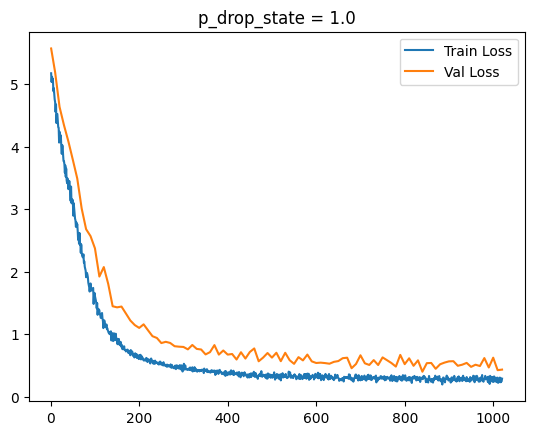

Last train loss: 0.28972649574279785
Last val loss: 0.4344523251056671


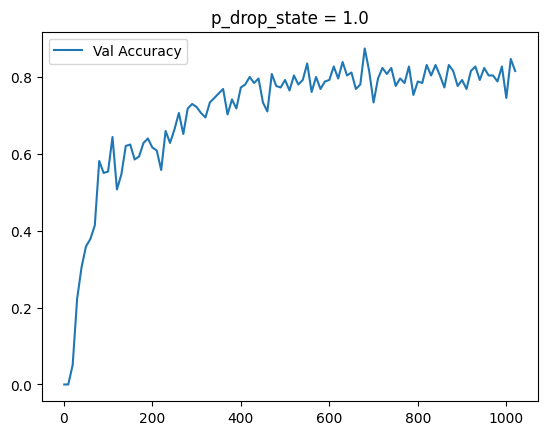

Last val accuracy: 0.81640625


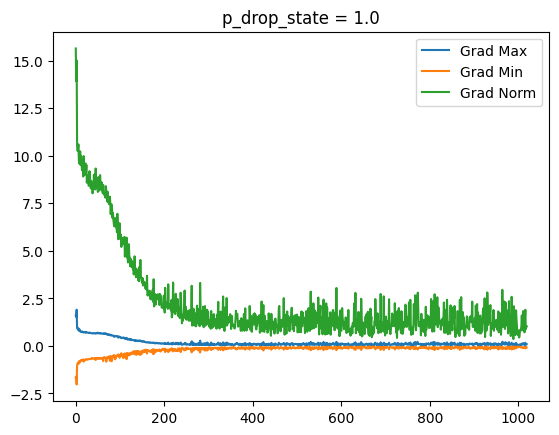

In [65]:
# visualize train and val losses lists on the same plot, scale val by VAL_INTERVAL
import matplotlib.pyplot as plt


train_x_vals = [x[0] for x in train_losses]
train_y_vals = [x[1] for x in train_losses]
val_x_vals = [x[0] for x in val_losses]
val_y_vals = [x[1] for x in val_losses]
plt.plot(train_x_vals, train_y_vals, label='Train Loss')
plt.plot(val_x_vals, val_y_vals, label='Val Loss')
plt.title(f"p_drop_state = {p_drop_state}")
plt.legend()
plt.show()
print(f"Last train loss: {train_y_vals[-1]}")
print(f"Last val loss: {val_y_vals[-1]}")

# plot val_accuracies
plt.plot(val_x_vals, [x[1] for x in val_accuracies], label='Val Accuracy')
plt.title(f"p_drop_state = {p_drop_state}")
plt.legend()
plt.show()
print(f"Last val accuracy: {val_accuracies[-1][1]}")

# also plot grad_max, grad_min, grad_norm
plt.plot([x[1] for x in grad_max], label='Grad Max')
plt.plot([x[1] for x in grad_min], label='Grad Min')
plt.plot([x[1] for x in grad_norm], label='Grad Norm')
plt.title(f"p_drop_state = {p_drop_state}")
plt.legend()
plt.show()

In [66]:
# # save classifier network
# save_dir = f'exp/multitask_RL/living_room_scene1_two_task_classifier'
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir, exist_ok=True)
# save_path = f'{save_dir}/step_{step}.pkl'
# with open(save_path, 'wb') as f:
#     pickle.dump(network.params, f)

# Testing

In [67]:
# testing time, first by simply calling on test-batches, then visualizing!!
all_test_demo_nums = val_demo_nums_to_use + test_demo_nums_to_use
all_test_dataset = get_libero_dataset(None, env_name, task_name, augmentation_type, augmentation_reward, keys_to_load, demo_nums_to_use_per_task=all_test_demo_nums, augmentation_dict=None)

num_test_steps = 100 # dataset object is implemented as infinite, but 100 should be good enough w/ a batch size of 256
test_num_correct, test_num_total = 0, 0
for i in tqdm.tqdm(range(num_test_steps), total=num_test_steps, desc="Testing"):
    test_batch = all_test_dataset.sample_sequence(batch_size, sequence_length=horizon_length, discount=discount)
    num_correct, num_total = accuracy(network, test_batch)
    test_num_correct += num_correct
    test_num_total += num_total
avg_test_acc = test_num_correct / test_num_total
print(f"Test accuracy of {p_drop_state}: {avg_test_acc}, {test_num_correct}/{test_num_total}")

# testing time, first by simply calling on test-batches, then visualizing!!
num_test_steps = 100 # dataset is infinite, but 100 should be good enough w/ a batch size of 256
test_num_correct_zero_action, test_num_total_zero_action = 0, 0
for i in tqdm.tqdm(range(num_test_steps), total=num_test_steps, desc="Testing"):
    test_batch = all_test_dataset.sample_sequence(batch_size, sequence_length=horizon_length, discount=discount)
    # zero out both images before feeding into accuracy()
    # test_batch['observations']['agentview_rgb'] = jnp.zeros_like(test_batch['observations']['agentview_rgb'])
    # test_batch['observations']['eye_in_hand_rgb'] = jnp.zeros_like(test_batch['observations']['eye_in_hand_rgb'])
    # zero out action
    test_batch['actions'] = jnp.zeros_like(test_batch['actions'])    
    num_correct, num_total = accuracy(network, test_batch)
    test_num_correct_zero_action += num_correct
    test_num_total_zero_action += num_total
avg_test_acc_zero_action = test_num_correct_zero_action / test_num_total_zero_action
print(f"Test accuracy with action zeroed out of {p_drop_state}: {avg_test_acc_zero_action}, {test_num_correct_zero_action}/{test_num_total_zero_action}")

🤪🤪🤪 augmentation_reward: False
all_tasks: ['pick_up_the_alphabet_soup_and_put_it_in_the_basket', 'pick_up_the_ketchup_and_put_it_in_the_basket']
suites: ['libero_90'], scenes: ['living_room_scene1']
🤪🤪🤪 all_libero_env_names: {'libero_90': ['libero_90-LIVING_ROOM_SCENE1_pick_up_the_alphabet_soup_and_put_it_in_the_basket', 'libero_90-LIVING_ROOM_SCENE1_pick_up_the_ketchup_and_put_it_in_the_basket']}
🤪🤪🤪 distinct_scenes: {'libero_90': ['LIVING_ROOM_SCENE1']}
😈😈😈 target_task_name='pick_up_the_alphabet_soup_and_put_it_in_the_basket'
😎😎😎 ONLY using [np.int64(40), np.int64(5), np.int64(49), np.int64(24), np.int64(47), np.int64(34), np.int64(44), np.int64(33)] demos for target_task: pick_up_the_alphabet_soup_and_put_it_in_the_basket
🥳🥳🥳 j=0 Dataset pick_up_the_alphabet_soup_and_put_it_in_the_basket has 1131, and zero_out_rewards=False, relabeled to target_task_name='pick_up_the_alphabet_soup_and_put_it_in_the_basket'
😈😈😈 target_task_name='pick_up_the_ketchup_and_put_it_in_the_basket'
😎😎😎 ONLY 

Testing: 100%|██████████| 100/100 [00:13<00:00,  7.53it/s]


Test accuracy of 1.0: 0.8036327958106995, 20573/25600


Testing: 100%|██████████| 100/100 [00:13<00:00,  7.46it/s]

Test accuracy with action zeroed out of 1.0: 0.5644921660423279, 14451/25600


# More Thorough Classifier Testing

🤪🤪🤪 augmentation_reward: False
all_tasks: ['pick_up_the_alphabet_soup_and_put_it_in_the_basket', 'pick_up_the_ketchup_and_put_it_in_the_basket']
suites: ['libero_90'], scenes: ['living_room_scene1']
🤪🤪🤪 all_libero_env_names: {'libero_90': ['libero_90-LIVING_ROOM_SCENE1_pick_up_the_alphabet_soup_and_put_it_in_the_basket', 'libero_90-LIVING_ROOM_SCENE1_pick_up_the_ketchup_and_put_it_in_the_basket']}
🤪🤪🤪 distinct_scenes: {'libero_90': ['LIVING_ROOM_SCENE1']}
😈😈😈 target_task_name='pick_up_the_alphabet_soup_and_put_it_in_the_basket'
😎😎😎 ONLY using [np.int64(40), np.int64(5), np.int64(49), np.int64(24), np.int64(47), np.int64(34), np.int64(44), np.int64(33)] demos for target_task: pick_up_the_alphabet_soup_and_put_it_in_the_basket
🥳🥳🥳 j=0 Dataset pick_up_the_alphabet_soup_and_put_it_in_the_basket has 1131, and zero_out_rewards=False, relabeled to target_task_name='pick_up_the_alphabet_soup_and_put_it_in_the_basket'
😈😈😈 target_task_name='pick_up_the_ketchup_and_put_it_in_the_basket'
😎😎😎 ONLY 

Testing to find failure: 100%|██████████| 125/125 [00:22<00:00,  5.51it/s]


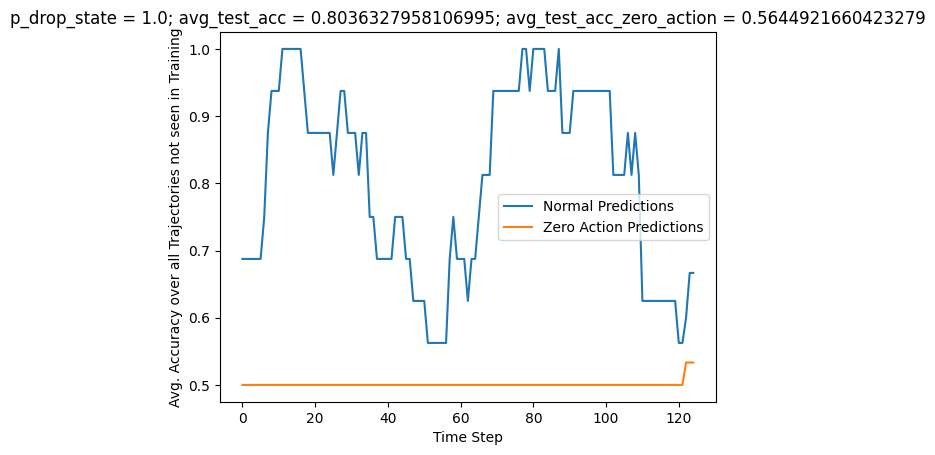

In [68]:
# combine val and test datasets
all_test_demo_nums = val_demo_nums_to_use + test_demo_nums_to_use
all_test_dataset = get_libero_dataset(None, env_name, task_name, augmentation_type, augmentation_reward, keys_to_load, demo_nums_to_use_per_task=all_test_demo_nums, augmentation_dict=None)
T = 125
regular_predictions_acc = []
zero_action_predictions_acc = []
# zero_image_predictions_acc = []
# zero_eye_in_hand_predictions_acc = []

for i in tqdm.tqdm(range(T), desc="Testing to find failure", total=T):
    test_batch = all_test_dataset.sample_sequence_at_trajectory_position(-1, horizon_length, discount, position=i)
    test_batch_copy = copy.deepcopy(test_batch)
    # test_batch_copy_2 = copy.deepcopy(test_batch)
    # test_batch_copy_3 = copy.deepcopy(test_batch)

    # visualize the first image in test_batch
    # im = test_batch['observations']['agentview_rgb'][0][::-1, ::-1, :]
    # plt.imshow(im)
    # plt.title(f"Task {test_batch['observations']['language'][0].argmax()}, timestep {i}")
    # plt.show()

    # no zeroing out
    num_correct, num_total = accuracy(network, test_batch)
    regular_predictions_acc.append(num_correct / num_total)
    
    test_batch_copy['actions'] = jnp.zeros_like(test_batch_copy['actions'])
    num_correct, num_total = accuracy(network, test_batch_copy)
    zero_action_predictions_acc.append(num_correct / num_total)

    # zeroing out images not actions
    # test_batch_copy_2['observations']['agentview_rgb'] = jnp.zeros_like(test_batch_copy_2['observations']['agentview_rgb'])
    # test_batch_copy_2['observations']['eye_in_hand_rgb'] = jnp.zeros_like(test_batch_copy_2['observations']['eye_in_hand_rgb'])
    # num_correct, num_total = accuracy(network, test_batch_copy_2)
    # zero_image_predictions_acc.append(num_correct / num_total)

    # # only zero out eye_in_hand_rgb
    # test_batch_copy_3['observations']['eye_in_hand_rgb'] = jnp.zeros_like(test_batch_copy_3['observations']['eye_in_hand_rgb'])
    # num_correct, num_total = accuracy(network, test_batch_copy_3)
    # zero_eye_in_hand_predictions_acc.append(num_correct / num_total)

    del test_batch, test_batch_copy

# line plot of normal_predictions_acc and zero_action_predictions_acc over time
plt.plot(regular_predictions_acc, label='Normal Predictions')
plt.plot(zero_action_predictions_acc, label='Zero Action Predictions')
plt.xlabel('Time Step')
plt.ylabel('Avg. Accuracy over all Trajectories not seen in Training')
# plt.plot(zero_image_predictions_acc, label='Zero Both Images Predictions')
# plt.plot(zero_eye_in_hand_predictions_acc, label='Zero Wrist Image Predictions')
plt.title(f"p_drop_state = {p_drop_state}; avg_test_acc = {avg_test_acc}; avg_test_acc_zero_action = {avg_test_acc_zero_action}")
plt.legend()
plt.show()


In [69]:
print('stop!')

stop!


In [ ]:
for _ in tqdm.tqdm(range(5), desc="Testing to find failure"):
    test_sample = test_dataset.sample_sequence(1, sequence_length=horizon_length, discount=discount)
    ims = [test_sample['observations'][k] for k in ['agentview_rgb', 'eye_in_hand_rgb']]
    # subplot
    
    true_lang = test_sample['observations']['language'][0].argmax()
    # print(f"True language: {true_lang.argmax()}")
    masked_actions = test_sample['actions'] * test_sample['masks'][..., None]
    flat_actions = jnp.reshape(masked_actions, (masked_actions.shape[0], -1))


    pred_lang = network.select('classifier')(test_sample['observations'], flat_actions, params=network.params).argmax()
    # print(f"Predicted language: {pred_lang.argmax()}")
    if True:
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(ims[0][0][::-1, ::-1, :])
        axs[1].imshow(ims[1][0][::-1, ::-1, :])
        plt.suptitle(f"True={true_lang}, Pred={pred_lang}")
        plt.show()

# Evaluation

In [15]:
eval_env, names_to_return = make_libero_env(
            env_name, 
            task_name,
            num_parallel_envs=5, 
            use_hardcoded_eval_envs=False, 
            keys_to_load=keys_to_load + ['proprio'], # need to add proprio as old actors were trained with proprio
            seed=0,
        )

TODO(YY): Normalization path not implemented for libero_90-living_room_scene1
evaluation environment will return keys:  {'robot0_eye_in_hand_image', 'agentview_image', 'language', 'proprio'}
all_tasks: ['pick_up_the_alphabet_soup_and_put_it_in_the_basket', 'pick_up_the_ketchup_and_put_it_in_the_basket']
suites: ['libero_90'], scenes: ['living_room_scene1']
All possible envs, sorted alphabetically: there are 1 total envs
 len(envs_to_eval)=2 Environments to evaluate: ['libero_90-LIVING_ROOM_SCENE1_pick_up_the_alphabet_soup_and_put_it_in_the_basket', 'libero_90-LIVING_ROOM_SCENE1_pick_up_the_ketchup_and_put_it_in_the_basket']


In [16]:
from agents.acifql import ACIFQLAgent, get_config as get_acifql_config

class ClassifierAgent:
    def __init__(self, network, actor_restore_path, example_batch, horizon_length, encoder):
        self.network = network
        self.actor_network = self.restore_actor_network(actor_restore_path, copy.deepcopy(example_batch), horizon_length)
        self.config = {"action_dim": example_batch["actions"].shape[-1], "horizon_length": horizon_length, "action_chunking": True, "encoder": encoder, "flow_steps": 10, "num_samples": 10}

    def restore_actor_network(self, actor_restore_path, example_batch, horizon_length):
        ex_observations = example_batch['observations']
        ex_actions = example_batch['actions']

        with open(actor_restore_path, 'rb') as f:
            load_dict = pickle.load(f)
        actor_agent_class = ACIFQLAgent
        actor_config = get_acifql_config()
        actor_config['encoder'] = 'combined_encoder_small'
        actor_config['horizon_length'] = horizon_length
        actor_agent = actor_agent_class.create(
            seed=SEED,
            ex_observations=copy.deepcopy(ex_observations),
            ex_actions=copy.deepcopy(ex_actions),
            config=actor_config,
        )
        loaded_actor_params = load_dict['agent']['network']['params']
        actor_agent_state_dict = flax.serialization.to_state_dict(actor_agent)
        actor_agent_params = actor_agent_state_dict['network']['params']

        for key in actor_agent_params:
            if 'actor' in key:
                # print(f"for key {key}, copying actor params from {config['actor_restore_path']}")
                actor_agent_params[key] = loaded_actor_params[key]
        actor_agent = flax.serialization.from_state_dict(actor_agent, actor_agent_state_dict)
        actor_network = actor_agent.network
        return actor_network
    
    def sample_actions(
        self,
        observations,
        rng=None,
        temperature=1.0,
    ):
        """Sample actions: actor_network generates actions, classifier used for rejection sampling."""

        if self.actor_network is None:
            raise ValueError("Actor network not found")

        full_action_dim = self.config["action_dim"] * (self.config["horizon_length"] if self.config["action_chunking"] else 1)
        k = sorted(observations.keys())[0]
        noises = jax.random.normal(
            rng,
            (
                observations[k].shape[0],
                self.config['num_samples'],
                full_action_dim,
            ),
        )
        observations = jax.tree_util.tree_map(
                    lambda x: jnp.repeat(x[:, None, ...], self.config["num_samples"], axis=1),
                    observations
                )
        actions = self.compute_flow_actions(observations, noises)
        actions = jnp.clip(actions, -1, 1)

        # Pick the action the classifier is most confident about, as measured by entropy
        pred_lang_logits = self.network.select('classifier')(observations, actions) # has shape (batch, num_samples, num_classes)
        # softmax-normalize and then compute entropy along axis=-1
        # More numerically stable entropy computation
        pred_lang_log_probs = jax.nn.log_softmax(pred_lang_logits, axis=-1)
        pred_lang_probs = jax.nn.softmax(pred_lang_logits, axis=-1)
        entropy = -jnp.sum(pred_lang_probs * pred_lang_log_probs, axis=-1)  # (batch, num_samples)
        
        indices = jnp.argmin(entropy, axis=-1)
        bshape = indices.shape
        indices = indices.reshape(-1)
        bsize = len(indices)
        actions = jnp.reshape(actions, (-1, self.config['num_samples'], full_action_dim))[jnp.arange(bsize), indices, :].reshape(
            bshape + (full_action_dim,))
        return actions

    
    def compute_flow_actions(
        self,
        observations,
        noises,
    ):
        """Compute actions from the BC flow model using the Euler method."""
        if self.config['encoder'] is not None:
            observations = self.actor_network.select('actor_flow_encoder')(observations)
        actions = noises
        # Euler method.
        for i in range(self.config['flow_steps']):
            t = jnp.full((*observations.shape[:-1], 1), i / self.config['flow_steps'])
            vels = self.actor_network.select('actor_flow')(observations, actions, t, is_encoded=True)
            actions = actions + vels / self.config['flow_steps']
        actions = jnp.clip(actions, -1, 1)
        return actions

In [17]:
actor_restore_path = 'exp/multitask_RL/bcflowactor_only/libero_90-living_room_scene1/bcflowactor_livingroomscene1__alphabet_soup_ketchup_25_demos_IMAGE_sd00020251227_144347/params_140000.pkl'
dataset_with_proprio = get_libero_dataset(None, env_name, task_name, augmentation_type, augmentation_reward, keys_to_load + ['proprio'], demo_nums_to_use_per_task=[1], augmentation_dict=None)
init_batch_for_actor = dataset_with_proprio.sample_sequence(1, sequence_length=horizon_length, discount=discount)
agent = ClassifierAgent(network, actor_restore_path, init_batch_for_actor, horizon_length, encoder)

🤪🤪🤪 augmentation_reward: False
all_tasks: ['pick_up_the_alphabet_soup_and_put_it_in_the_basket', 'pick_up_the_ketchup_and_put_it_in_the_basket']
suites: ['libero_90'], scenes: ['living_room_scene1']
🤪🤪🤪 all_libero_env_names: {'libero_90': ['libero_90-LIVING_ROOM_SCENE1_pick_up_the_alphabet_soup_and_put_it_in_the_basket', 'libero_90-LIVING_ROOM_SCENE1_pick_up_the_ketchup_and_put_it_in_the_basket']}
🤪🤪🤪 distinct_scenes: {'libero_90': ['LIVING_ROOM_SCENE1']}
😈😈😈 target_task_name='pick_up_the_alphabet_soup_and_put_it_in_the_basket'
😎😎😎 ONLY using [1] demos for target_task: pick_up_the_alphabet_soup_and_put_it_in_the_basket
🥳🥳🥳 j=0 Dataset pick_up_the_alphabet_soup_and_put_it_in_the_basket has 124, and zero_out_rewards=False, relabeled to target_task_name='pick_up_the_alphabet_soup_and_put_it_in_the_basket'
😈😈😈 target_task_name='pick_up_the_ketchup_and_put_it_in_the_basket'
😎😎😎 ONLY using [1] demos for target_task: pick_up_the_ketchup_and_put_it_in_the_basket
🥳🥳🥳 j=1 Dataset pick_up_the_ket

In [18]:
# now let's try to do evaluation with this classifier network!!
# change spawn method
all_eval_info = []
per_eval_videos = {}
for j, eval_env_j in tqdm.tqdm(enumerate(eval_env), total=len(eval_env), desc="Evaluating multi-task", position=0,leave=False):
    eval_info, trajs, renders = evaluate(
        agent=agent,
        env=eval_env_j,
        action_dim=example_batch["actions"].shape[-1],
        num_eval_episodes=50,
        num_video_episodes=5,
        num_parallel_envs=5,
        video_frame_skip=3,
    )
    all_eval_info.append(eval_info)
    if len(renders) > 0:
        # value_and_reward_visualization(trajs, agent, FLAGS.save_dir, log_step)
        per_eval_videos[names_to_return[j]] = get_wandb_video(renders)

# aggregate eval info via mean, then log under "eval" prefix
mean_eval_info = {k: np.mean([eval_info[k] for eval_info in all_eval_info]) for k in all_eval_info[0].keys()}

Evaluating multi-task:   0%|          | 0/2 [00:00<?, ?it/s]2026-01-03 23:16:11.486376: F external/xla/xla/stream_executor/cuda/cuda_context.cc:187] Non-OK-status: cuda::ToStatus(cuCtxSetCurrent(context_), "Failed setting context")
Status: INTERNAL: CUDA error: Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error


EOFError: 

2026-01-03 23:16:12.576238: F external/xla/xla/stream_executor/cuda/cuda_context.cc:187] Non-OK-status: cuda::ToStatus(cuCtxSetCurrent(context_), "Failed setting context")
Status: INTERNAL: CUDA error: Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2026-01-03 23:16:12.612484: F external/xla/xla/stream_executor/cuda/cuda_context.cc:187] Non-OK-status: cuda::ToStatus(cuCtxSetCurrent(context_), "Failed setting context")
Status: INTERNAL: CUDA error: Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2026-01-03 23:16:12.640998: F external/xla/xla/stream_executor/cuda/cuda_context.cc:187] Non-OK-status: cuda::ToStatus(cuCtxSetCurrent(context_), "Failed setting context")
Status: INTERNAL: CUDA error: Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2026-01-03 23:16:12.960347: F external/xla/xla/stream_executor/cuda/cuda_context.cc:187] Non-OK-status: cuda::ToStatus(cuCtxSetCurrent(context_), "Failed setting context")
Sta

In [13]:
# visualize results :)
all_eval_path = '/home/yajatyadav/multitask_reinforcement_learning/multitask_RL/all_eval_info.pkl'
mean_eval_path = '/home/yajatyadav/multitask_reinforcement_learning/multitask_RL/mean_eval_info.pkl'
per_eval_videos_path = '/home/yajatyadav/multitask_reinforcement_learning/multitask_RL/per_eval_videos.pkl'

In [14]:
# open all_eval_path and mean_eval_path and per_eval_videos_path and read the contents
import pickle
with open(all_eval_path, 'rb') as f:
    all_eval_info = pickle.load(f)
with open(mean_eval_path, 'rb') as f:
    mean_eval_info = pickle.load(f)
with open(per_eval_videos_path, 'rb') as f:
    per_eval_videos = pickle.load(f)

In [31]:
print(all_eval_info)

[defaultdict(<class 'list'>, {'success': np.float64(0.46), 'env_id': np.float64(2.0)}), defaultdict(<class 'list'>, {'success': np.float64(0.7), 'env_id': np.float64(2.0)})]


In [30]:
from IPython.display import Video, display
import shutil
import os

# Copy video to current directory
k = list(per_eval_videos.keys())[0]
video_path = per_eval_videos[k]._path
new_path = f"./video_{id(per_eval_videos[k])}.mp4"
shutil.copy(video_path, new_path)

# Display from new location
display(Video(new_path, embed=True))

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpmuf6mqecwandb-media/i7up5r4f.mp4'